In [1]:
# cell 1 — setup, installs & reproducibility
# If you're in Colab and get errors, uncomment:
# !pip install -q tensorflow matplotlib scikit-learn

import os, random, numpy as np
import tensorflow as tf

SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("TensorFlow:", tf.__version__)
print("GPU available:", len(tf.config.list_physical_devices('GPU')) > 0)

2025-09-06 20:56:29.272415: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-06 20:56:29.281134: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757170589.290764   21834 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757170589.293696   21834 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1757170589.301487   21834 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

TensorFlow: 2.19.0
GPU available: True


In [2]:
# cell 2 (UPDATED) — imports
# Add t-SNE and (optionally) UMAP imports

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE  # NEW

from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import layers, models

# UMAP (pip install umap-learn) — we import lazily later to avoid failing if not installed.


In [3]:
# cell 3 — load MNIST dataset

(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

# small subset to keep runtime low
NUM_TRAIN, NUM_TEST = 60000, 10000
images_all = np.concatenate([train_images[:NUM_TRAIN], test_images[:NUM_TEST]], axis=0)
labels_all = np.concatenate([train_labels[:NUM_TRAIN], test_labels[:NUM_TEST]], axis=0)

print("Raw dataset shapes:", images_all.shape, labels_all.shape)

Raw dataset shapes: (70000, 28, 28) (70000,)


In [4]:
# cell 4 — preprocessing: grayscale → RGB, resize → 32x32, VGG16 normalization

# scale to [0,1]
images_all = images_all.astype("float32") / 255.0

# add channel dimension → (N,28,28,1) then replicate to RGB → (N,28,28,3)
images_all = np.expand_dims(images_all, -1)
images_all = np.repeat(images_all, 3, axis=-1)

# resize to 32x32
images_all = tf.image.resize(images_all, (32, 32)).numpy()

# VGG16 preprocessing (BGR ordering, mean subtraction, scaling)
images_all = preprocess_input(images_all * 255.0)

print("Preprocessed shape:", images_all.shape, "dtype:", images_all.dtype)

I0000 00:00:1757170591.492360   21834 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6083 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6


Preprocessed shape: (70000, 32, 32, 3) dtype: float32


In [5]:
# cell 5 — shuffle and split (80/20 train/validation)
      
from sklearn.model_selection import train_test_split
X_train,X_test, y_train,y_test = train_test_split(images_all,labels_all,test_size=0.15,shuffle=True,random_state=42)

images_train = X_train
images_val = X_test

labels_train = y_train
labels_val = y_test

print(images_val.shape)
print(labels_val.shape)

(10500, 32, 32, 3)
(10500,)


In [6]:
# Cell 6 

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

resnet50_base = ResNet50(
    weights="imagenet",
    include_top=False,
    pooling="avg",
    input_shape=(32, 32, 3)
)
resnet50_base.trainable = False

sample_features = resnet50_base.predict(images_val[:8], verbose=0)

I0000 00:00:1757170594.363493   21916 service.cc:152] XLA service 0x7c40d00019d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757170594.363510   21916 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2025-09-06 20:56:34.403484: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1757170594.714045   21916 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1757170595.827538   21916 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [7]:
resnet50_base.summary(show_trainable=True)

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer       │ (None, 32, 32,  │         0 │ -              │   -   │
│ (InputLayer)      │ 3)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv1_pad         │ (None, 38, 38,  │         0 │ input_layer[0… │   -   │
│ (ZeroPadding2D)   │ 3)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv1_conv        │ (None, 16, 16,  │     9,472 │ conv1_pad[0][… │   N   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv1_bn          │ (None, 16, 16,  │       256 │ conv1_conv[0]… │   N   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv1_relu        │ (None, 16, 16,  │         0 │ conv1_bn[0][0] │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ pool1_pad         │ (None, 18, 18,  │         0 │ conv1_relu[0]… │   -   │
│ (ZeroPadding2D)   │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ pool1_pool        │ (None, 8, 8,    │         0 │ pool1_pad[0][… │   -   │
│ (MaxPooling2D)    │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2_block1_1_c… │ (None, 8, 8,    │     4,160 │ pool1_pool[0]… │   N   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2_block1_1_bn │ (None, 8, 8,    │       256 │ conv2_block1_… │   N   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2_block1_1_r… │ (None, 8, 8,    │         0 │ conv2_block1_… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2_block1_2_c… │ (None, 8, 8,    │    36,928 │ conv2_block1_… │   N   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2_block1_2_bn │ (None, 8, 8,    │       256 │ conv2_block1_… │   N   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2_block1_2_r… │ (None, 8, 8,    │         0 │ conv2_block1_… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2_block1_0_c… │ (None, 8, 8,    │    16,640 │ pool1_pool[0]… │   N   │
│ (Conv2D)          │ 256)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2_block1_3_c… │ (None, 8, 8,    │    16,640 │ conv2_block1_… │   N   │
│ (Conv2D)          │ 256)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2_block1_0_bn │ (None, 8, 8,    │     1,024 │ conv2_block1_… │   N   │
│ (BatchNormalizat… │ 256)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2_block1_3_bn │ (None, 8, 8,    │     1,024 │ conv2_block1_… │   N 

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step


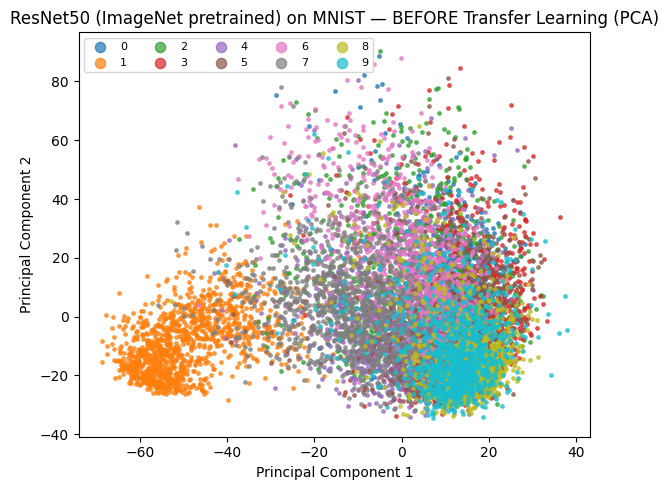

In [8]:
# cell 7 — BEFORE transfer: extract features and PCA
def plot_pca_scatter(points_2d, labels, title,xlabel,ylabel):
    plt.figure(figsize=(6,5))
    for digit in range(10):
        mask = labels == digit
        plt.scatter(points_2d[mask,0], points_2d[mask,1], 
                    s=6, alpha=0.7, label=str(digit))
    plt.title(title)
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.legend(markerscale=3, fontsize=8, ncol=5)
    plt.tight_layout()
    plt.show()

features_before = resnet50_base.predict(
    images_val, 
    batch_size=128, 
    verbose=1)

pca_before = PCA(n_components=2, random_state=SEED).fit_transform(features_before)

plot_pca_scatter(pca_before, labels_val,
    "ResNet50 (ImageNet pretrained) on MNIST — BEFORE Transfer Learning (PCA)",
    "Principal Component 1",
    "Principal Component 2")

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10500 samples in 0.005s...
[t-SNE] Computed neighbors for 10500 samples in 1.787s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10500
[t-SNE] Computed conditional probabilities for sample 2000 / 10500
[t-SNE] Computed conditional probabilities for sample 3000 / 10500
[t-SNE] Computed conditional probabilities for sample 4000 / 10500
[t-SNE] Computed conditional probabilities for sample 5000 / 10500
[t-SNE] Computed conditional probabilities for sample 6000 / 10500
[t-SNE] Computed conditional probabilities for sample 7000 / 10500
[t-SNE] Computed conditional probabilities for sample 8000 / 10500
[t-SNE] Computed conditional probabilities for sample 9000 / 10500
[t-SNE] Computed conditional probabilities for sample 10000 / 10500
[t-SNE] Computed conditional probabilities for sample 10500 / 10500
[t-SNE] Mean sigma: 9.443564
[t-SNE] KL divergence after 250 iterations with early exaggeration: 88.510666
[t-SNE] KL 

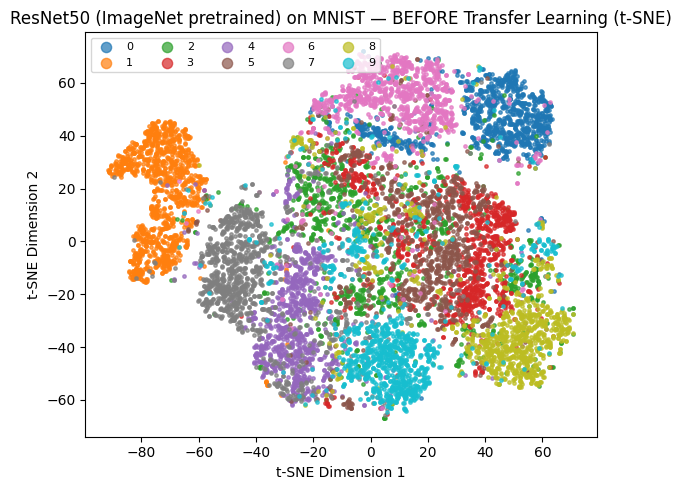

In [9]:
# cell 7a — BEFORE transfer: t-SNE (2D)

# Tip: t-SNE works best on a few thousand points; our ~1.6k val set is fine.
tsne_before = TSNE(
    n_components=2,
    init="pca",
    learning_rate="auto",
    perplexity=30,          # if you plot only 100 points, reduce to ~15
    max_iter=1000,
    random_state=SEED,
    verbose=1
).fit_transform(features_before)


# plot all or a subset (e.g., first 100)
plot_pca_scatter(tsne_before, labels_val,
    "ResNet50 (ImageNet pretrained) on MNIST — BEFORE Transfer Learning (t-SNE)",
    "t-SNE Dimension 1",
    "t-SNE Dimension 2")
# or: plot_pca_scatter(tsne_before[:100], labels_val[:100], "... (t-SNE, first 100)")


/home/akif/miniconda3/envs/vision/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP(n_jobs=1, random_state=42, verbose=True)
Sat Sep  6 20:57:00 2025 Construct fuzzy simplicial set
Sat Sep  6 20:57:00 2025 Finding Nearest Neighbors
Sat Sep  6 20:57:00 2025 Building RP forest with 10 trees
Sat Sep  6 20:57:03 2025 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	 4  /  13
	Stopping threshold met -- exiting after 4 iterations
Sat Sep  6 20:57:08 2025 Finished Nearest Neighbor Search
Sat Sep  6 20:57:09 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sat Sep  6 20:57:12 2025 Finished embedding


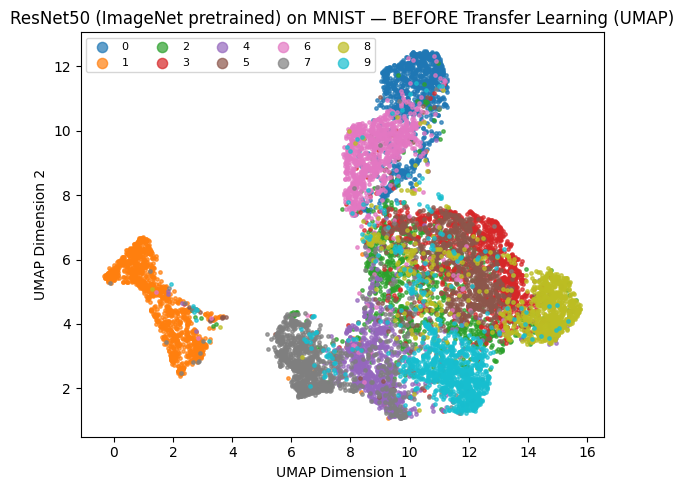

In [10]:
# cell 7b — BEFORE transfer: UMAP (2D)

import umap  # requires: pip install umap-learn

umap_before = umap.UMAP(
    n_components=2,
    n_neighbors=15,     # local structure; try 10–50
    min_dist=0.1,       # tighter (0.0–0.5)
    metric="euclidean",
    random_state=SEED,
    verbose=True
).fit_transform(features_before)

plot_pca_scatter(umap_before, labels_val,
    "ResNet50 (ImageNet pretrained) on MNIST — BEFORE Transfer Learning (UMAP)",
    "UMAP Dimension 1",
    "UMAP Dimension 2")

# or: plot_pca_scatter(umap_before[:100], labels_val[:100], "... (UMAP, first 100)")


In [11]:
for layer in resnet50_base.layers:
    if "conv5" in layer.name:    # fine-tune only the last block
        layer.trainable = True
    else:
        layer.trainable = False

input_layer = layers.Input(shape=(32, 32, 3))
feature_vector = resnet50_base(input_layer, training=True)
output_layer = layers.Dense(10, activation="softmax")(feature_vector)
transfer_model = models.Model(input_layer, output_layer)

Epoch 1/5


2025-09-06 20:57:19.736684: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6672', 60 bytes spill stores, 60 bytes spill loads

2025-09-06 20:57:19.874017: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6672', 3840 bytes spill stores, 3808 bytes spill loads

2025-09-06 20:57:20.049045: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6672', 3620 bytes spill stores, 3612 bytes spill loads



463/465 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8339 - loss: 0.5592

2025-09-06 20:57:28.372663: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6672', 4 bytes spill stores, 4 bytes spill loads

2025-09-06 20:57:28.532015: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6672_0', 4 bytes spill stores, 4 bytes spill loads

2025-09-06 20:57:28.538379: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6672', 76 bytes spill stores, 76 bytes spill loads

2025-09-06 20:57:28.652941: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6858', 8 bytes spill stores, 8 bytes spill loads

2025-09-06 20:57:28.780692: I external/local

465/465 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8342 - loss: 0.5579

2025-09-06 20:57:35.731416: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1696', 768 bytes spill stores, 768 bytes spill loads



465/465 ━━━━━━━━━━━━━━━━━━━━ 23s 29ms/step - accuracy: 0.9179 - loss: 0.2728 - val_accuracy: 0.9602 - val_loss: 0.1228
Epoch 2/5
465/465 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9864 - loss: 0.0450 - val_accuracy: 0.9669 - val_loss: 0.1109
Epoch 3/5
465/465 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9978 - loss: 0.0096 - val_accuracy: 0.9722 - val_loss: 0.1138
Epoch 4/5
465/465 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9965 - loss: 0.0118 - val_accuracy: 0.9607 - val_loss: 0.1595
Epoch 5/5
465/465 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9904 - loss: 0.0289 - val_accuracy: 0.9673 - val_loss: 0.1209
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


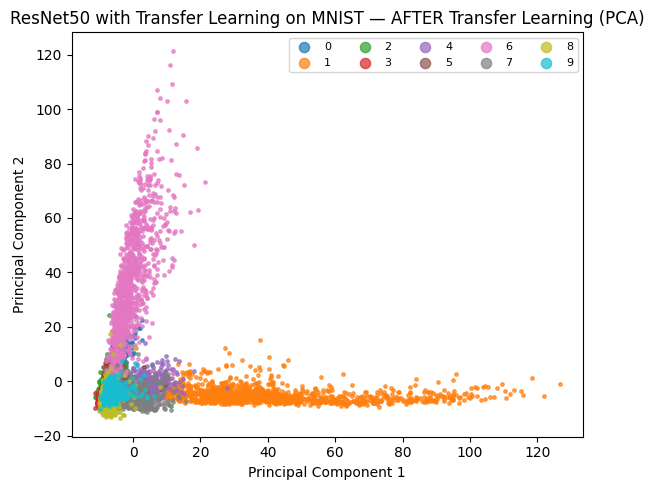

In [12]:
# compile the model
transfer_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# fit on training data
history = transfer_model.fit(
    images_train, labels_train,
    epochs=5,                   # or more if resources allow
    batch_size=128,
    validation_data=(images_val, labels_val),
    verbose=1
)

features_after = resnet50_base.predict(images_val, batch_size=128, verbose=1)
pca_after = PCA(n_components=2, random_state=SEED).fit_transform(features_after)

plot_pca_scatter(pca_after, labels_val,
    "ResNet50 with Transfer Learning on MNIST — AFTER Transfer Learning (PCA)",
    "Principal Component 1",
    "Principal Component 2")

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10500 samples in 0.005s...
[t-SNE] Computed neighbors for 10500 samples in 1.782s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10500
[t-SNE] Computed conditional probabilities for sample 2000 / 10500
[t-SNE] Computed conditional probabilities for sample 3000 / 10500
[t-SNE] Computed conditional probabilities for sample 4000 / 10500
[t-SNE] Computed conditional probabilities for sample 5000 / 10500
[t-SNE] Computed conditional probabilities for sample 6000 / 10500
[t-SNE] Computed conditional probabilities for sample 7000 / 10500
[t-SNE] Computed conditional probabilities for sample 8000 / 10500
[t-SNE] Computed conditional probabilities for sample 9000 / 10500
[t-SNE] Computed conditional probabilities for sample 10000 / 10500
[t-SNE] Computed conditional probabilities for sample 10500 / 10500
[t-SNE] Mean sigma: 15.484631
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.915718
[t-SNE] KL

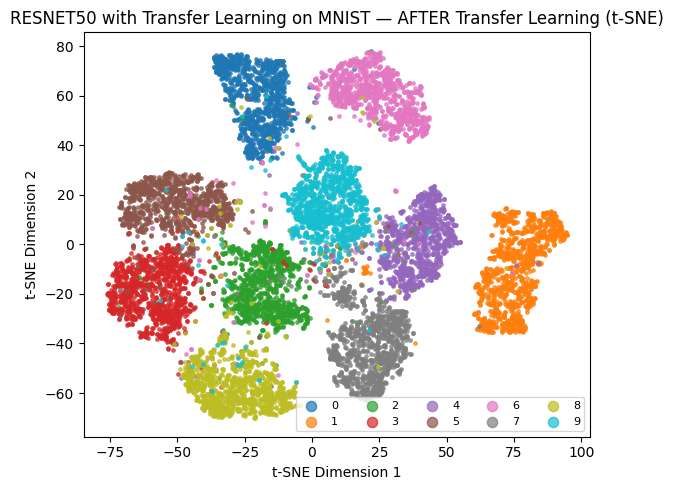

In [13]:
# cell 9a — AFTER transfer: t-SNE (2D)

tsne_after = TSNE(
    n_components=2,
    init="pca",
    learning_rate="auto",
    perplexity=30,       # if plotting first 100 only, use ~15
    max_iter=1000,
    random_state=SEED,
    verbose=1
).fit_transform(features_after)

plot_pca_scatter(tsne_after, labels_val,
    "RESNET50 with Transfer Learning on MNIST — AFTER Transfer Learning (t-SNE)",
    "t-SNE Dimension 1",
    "t-SNE Dimension 2")

# or: plot_pca_scatter(tsne_after[:100], labels_val[:100], "... (t-SNE, first 100)")


/home/akif/miniconda3/envs/vision/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP(n_jobs=1, random_state=42, verbose=True)
Sat Sep  6 20:58:12 2025 Construct fuzzy simplicial set
Sat Sep  6 20:58:12 2025 Finding Nearest Neighbors
Sat Sep  6 20:58:12 2025 Building RP forest with 10 trees
Sat Sep  6 20:58:12 2025 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	 4  /  13
	Stopping threshold met -- exiting after 4 iterations
Sat Sep  6 20:58:13 2025 Finished Nearest Neighbor Search
Sat Sep  6 20:58:13 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sat Sep  6 20:58:17 2025 Finished embedding


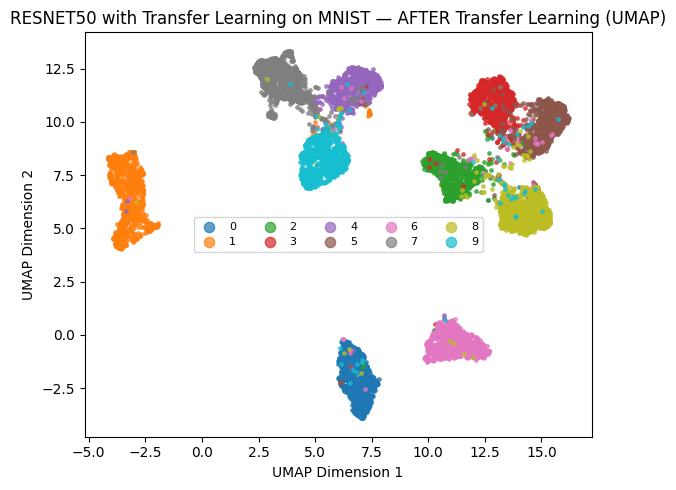

In [14]:
# cell 9b — AFTER transfer: UMAP (2D)

umap_after = umap.UMAP(
    n_components=2,
    n_neighbors=15,
    min_dist=0.1,
    metric="euclidean",
    random_state=SEED,
    verbose=True
).fit_transform(features_after)

plot_pca_scatter(umap_after, labels_val,
    "RESNET50 with Transfer Learning on MNIST — AFTER Transfer Learning (UMAP)",
    "UMAP Dimension 1",
    "UMAP Dimension 2")

# or: plot_pca_scatter(umap_after[:100], labels_val[:100], "... (UMAP, first 100)")


In [ ]:
# cell 10 — optional quantitative cluster measure

def mean_within_class_variance(points_2d, labels):
    variances = []
    for digit in range(10):
        class_points = points_2d[labels == digit]
        if len(class_points) > 1:
            variances.append(np.mean(np.var(class_points, axis=0)))
    return float(np.mean(variances)) if variances else np.nan

print("Within-class variance (lower = tighter clusters)")

print("  BEFORE with PCA:", mean_within_class_variance(pca_before, labels_val))
print("  AFTER with PCA :", mean_within_class_variance(pca_after,  labels_val))

print("  BEFORE with TSNE:", mean_within_class_variance(tsne_before, labels_val))
print("  AFTER with TSNE :", mean_within_class_variance(tsne_after,  labels_val))

print("  BEFORE with UMAP:", mean_within_class_variance(umap_before, labels_val))
print("  AFTER with UMAP :", mean_within_class_variance(umap_after,  labels_val))


Within-class variance (lower = tighter clusters)
  BEFORE with PCA: 210.2295684814453
  AFTER with PCA : 56.92046356201172
  BEFORE with TSNE: 388.76849365234375
  AFTER with TSNE : 154.90554809570312
  BEFORE with UMAP: 1.816738486289978
  AFTER with UMAP : 1.4981434345245361


: 